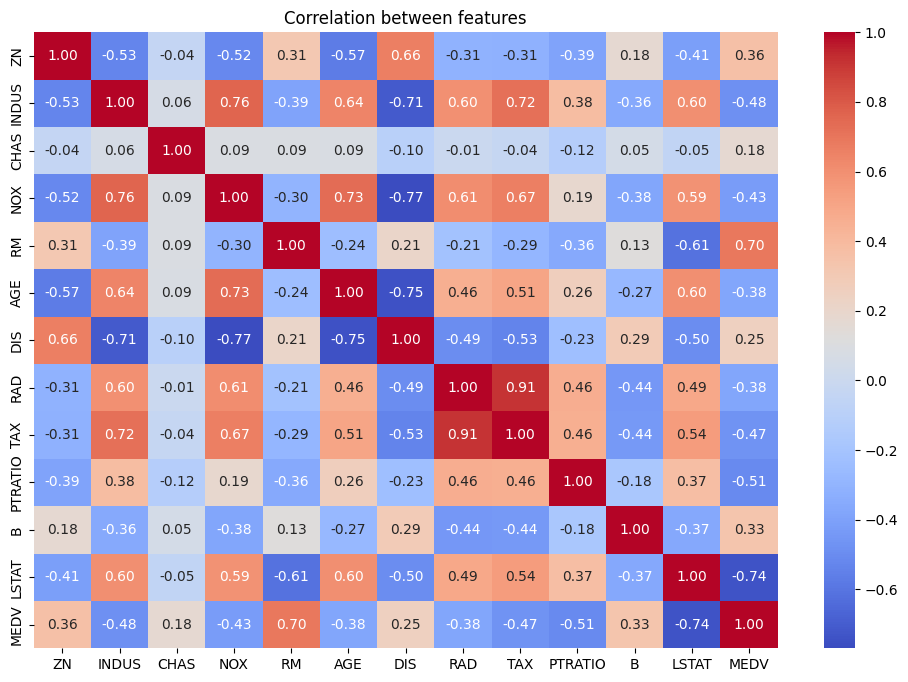

Best parameters found:  {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}
MSE: 43.393284718882185
R2: 0.49213193881813544
MAE: 2.7279693200881985
MAPE: 10.270497423801947
RMSE: 6.036930762565909
    Actual  Predicted     Error
0  0.00632  -2.310213  2.316533
1  0.02731  -1.727626  1.754936
2  0.02729  -2.545401  2.572691
3  0.03237  -0.769732  0.802102
4  0.06905  -1.310194  1.379244


c:\WorkSpace\Practice\env2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


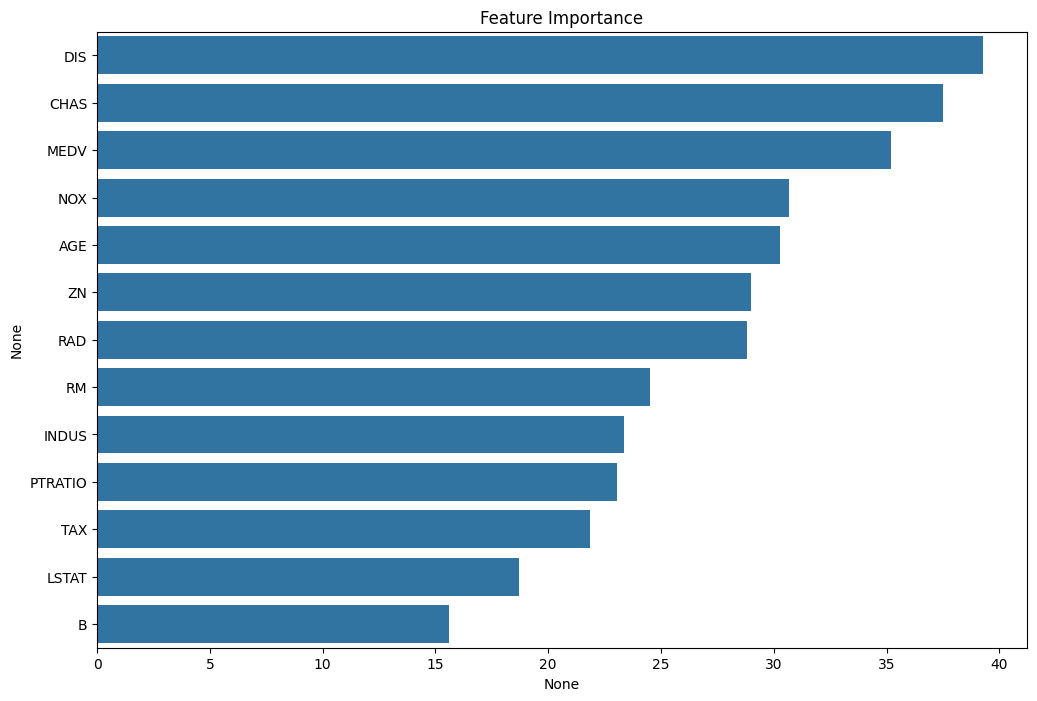

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest, f_regression

# CSVファイルの読み込み
file_path = 'C:/Users/thisi/OneDrive/デスクトップ/Dateset1.csv'  # CSVファイルのパスを指定してください
df = pd.read_csv(file_path)

# 目的変数と説明変数の設定
target_variable = 'CRIM'  # 目的変数を指定してください
X = df.drop(columns=[target_variable])
y = df[target_variable]

# 説明変数間の相関関係を示す画像を出力
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation between features')
plt.show()

# データの標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 特徴量選択（任意）
selector = SelectKBest(f_regression, k='all')
X_scaled = selector.fit_transform(X_scaled, y)

# データ分割
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ハイパーパラメータの設定とGridSearchCVによるチューニング
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
mlp = MLPRegressor(max_iter=1000)
grid_search = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=3)
grid_search.fit(X_train, y_train)

# 最適なハイパーパラメータ
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# k分割交差検定
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_list, r2_list, mae_list, mape_list, rmse_list = [], [], [], [], []

for train_index, val_index in kf.split(X_scaled):
    X_kf_train, X_kf_val = X_scaled[train_index], X_scaled[val_index]
    y_kf_train, y_kf_val = y[train_index], y[val_index]
    
    model = MLPRegressor(**best_params, max_iter=1000)
    model.fit(X_kf_train, y_kf_train)
    
    y_pred = model.predict(X_kf_val)
    
    mse = mean_squared_error(y_kf_val, y_pred)
    r2 = r2_score(y_kf_val, y_pred)
    mae = mean_absolute_error(y_kf_val, y_pred)
    mape = mean_absolute_percentage_error(y_kf_val, y_pred)
    rmse = np.sqrt(mse)
    
    mse_list.append(mse)
    r2_list.append(r2)
    mae_list.append(mae)
    mape_list.append(mape)
    rmse_list.append(rmse)

# 評価指標の出力
print(f'MSE: {np.mean(mse_list)}')
print(f'R2: {np.mean(r2_list)}')
print(f'MAE: {np.mean(mae_list)}')
print(f'MAPE: {np.mean(mape_list)}')
print(f'RMSE: {np.mean(rmse_list)}')

# 全データセットに対して予測を行う
model.fit(X_scaled, y)
y_pred = model.predict(X_scaled)

# 実測値と予測値の誤差を出力
errors = y - y_pred
results = pd.DataFrame({'Actual': y, 'Predicted': y_pred, 'Error': errors})
print(results.head())

# 予測結果をCSVファイルに出力
results.to_csv('NeuralNetworks_prediction_results.csv', index=False)

# 特徴量の重要度を示す画像を出力
importances = np.abs(model.coefs_[0]).sum(axis=1)
feature_importances = pd.Series(importances, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importance')
plt.show()
